find cluster for original data
find cluster for permutation data

输入是从R那里得到的时空点的t p csv文档。

你算中介model的时候其实有两类
1 每个点都算
2 时间切片酸



这段代码的函数有被重用的可能性，其实应该弄到 .py 文件里，调用来使用。

这样你就不用每次跑到这个脚本里来跑代码，而是在单一的 脚本文件里 调用就行

那直接把脚本转换成

----

why use p value rather than t value to find clusters?

notice: you cannot use t-threshold to find clusters, because there is no constant t threshold for 
each temporal-spatial point.
For each temporal-spatial point, the t-threshold is different.
Because the degree of freedom is different for linear mixed model!

So you read the rds file to load summary results, and extract the p value for each temporal-spatial point.
we have to use the p value to find clusters.



calculate the permutation sum-t

prodedure:
1 calculate sum-t
'''

In [1]:
import os
import glob
import mne
import mne.stats.cluster_level_backup as cluster_level_backup
from importlib import reload
import utils_EEG.stuff as stuff
from concurrent.futures import ProcessPoolExecutor, as_completed
from mne.channels import find_ch_adjacency
import pandas as pd
import numpy as np
from datetime import datetime
# Reload custom module to ensure latest changes
reload(stuff)

reload ok
reload stuff module
D:\ProgramData\anaconda3\envs\mne12\python.exe
导入成功
reload stuff module
D:\ProgramData\anaconda3\envs\mne12\python.exe
导入成功


<module 'utils_EEG.stuff' from 'D:\\LYW\\pre10\\utils_EEG\\stuff.py'>

## define function to find clusters using sum-t method from csv file with p-values

用p还是用t，需要改两个地方
1 除了设定 threshold_type 为 'p' 或 't' 外
2 还要把 p_values 放到参数中

    threshold_type= threshold_type, # 'p' or 't'

    Extract the p-values column
    p_values = data['p_value'].values # if you want to use p-values instead of t-values
    p_values=p_values # if you want to use p-values instead of t-values
        




In [2]:
# Modify the process_csv_file function to use sum-t clustering
# include
# find cluster 
def calculate_sumT_from_csv_file(
        csv_file_path,
        adjacency2, 
        test_iterations,
        sigma, 
        threshold_sum_t, 
        max_step, 
        t_power, 
        threshold_type):

    print(f"Processing {csv_file_path}")

    '''
    why don't you use cluster_level_backup.spatio_temporal_cluster_test() directly?
    because you didn't add a new parameter to read csv file.
    '''

    # Compute t based on the csv file
    # using coef_estimate and std_error from csv file
    # and sigma to smooth the t values.
    # I should change the function name to calculate_t_values_from_csv_file。。。
    # smoothing..
    # if you don't need smoothing, then set sigma = 0 or load from csv file directly
    t_obs_orig_permu = stuff.apply_lmer_models_to_array_parallel_hat(
        array_of_dfs=None,
        test_iterations=test_iterations,#useless
        max_workers=5,# useless,no parallel process in this version function.
        sigma=sigma,
        csv_file_path=csv_file_path # default csv file path: summary_results_2024年11月14日.csv
    )

    # load p-values from csv file
    data = pd.read_csv(csv_file_path)
    
    # Extract the p-values column
    p_values = data['p_value'].values # if you want to use p-values instead of t-values

    # Calculate max and min values of t_obs_orig_permu
    max_t_obs = np.max(t_obs_orig_permu)
    min_t_obs = np.min(t_obs_orig_permu)
    print(f"Max value of t_obs_orig_permu: {max_t_obs}")
    print(f"Min value of t_obs_orig_permu: {min_t_obs}")

    # Find clusters using sum-t method
    # I have to change the function to use p-values instead of t-values for the clustering.
    out = cluster_level_backup._find_clusters_TorP(
        x=t_obs_orig_permu,
        threshold=threshold_sum_t,
        tail=tail,
        adjacency=adjacency2,
        max_step=max_step,
        include=None,
        partitions=None,
        t_power=t_power,
        show_info=True,
        # additional
        threshold_type= threshold_type, # 'p' or 't'
        p_values=p_values # if you want to use p-values instead of t-values
    )
    clustersT, clusterT_sum = out

    return csv_file_path, {'out': out} # if you want all cluster information, you can return it.
    # # Calculate min and max of cluster sums
    # min_cluster_sum = np.min(clusterT_sum)
    # max_cluster_sum = np.max(clusterT_sum)
    #
    # return csv_file_path, min_cluster_sum, max_cluster_sum


# Define the set of channels to use (excluding FT9, FT10, TP9, TP10)
channels_all = [
    'Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4',
    'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8',
    'Fz', 'Cz', 'Pz', 'FC1', 'FC2', 'CP1', 'CP2',
    'FC5', 'FC6', 'CP5', 'CP6', 'F1', 'F2', 'C1',
    'C2', 'P1', 'P2', 'AF3', 'AF4', 'FC3', 'FC4',
    'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5',
    'C6', 'P5', 'P6', 'AF7', 'AF8', 'FT7', 'FT8',
    'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'CPz', 'POz', 'Oz'
]

# Load an evoked file as an example
file_path = r"D:\LYW\pre10\data\7evoked_allWords\prex006-ave.fif"
evoked_example = mne.read_evokeds(file_path, proj=False, verbose=None)
evoked_example = evoked_example[0].resample(91)  # Resample to 91 Hz
evoked_example.pick_channels(channels_all)  # Select a subset of channels

# Compute adjacency for the chosen channels
info = evoked_example.info
adjacency, ch_names = find_ch_adjacency(info, ch_type="eeg")

# Set parameters related to cluster analysis
max_step = 1
t_power = 1
n_tests = 59 * 91
n_times = 91

# Setup adjacency structure required for TFCE calculations
adjacency2 = cluster_level_backup._setup_adjacency(adjacency, n_tests, n_times)

test_iterations = 5733 # useless


Reading D:\LYW\pre10\data\7evoked_allWords\prex006-ave.fif ...
    Found the data of interest:
        t =    -200.00 ...     800.00 ms (0.40 × 100 + 0.20 × 101 + 0.20 × 102 + 0.20 × 103)
        0 CTF compensation matrices available
        nave = 250 - aspect type = 100
Loaded Evoked data is baseline-corrected (baseline: [-0.2, 0] s)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 59


## 找cluster 

bug: 为何算出来的sum_T 都是inf?

用t或者用p要改两个地方：
threshold_sum_t = 0.01 # if you set threshold_type='p',
threshold_sum_t = 1.96 # if you set threshold_type='t',
    'p' # if you set threshold_type='p',
    't' # if you set threshold_type='t',


无论是对多个permutation的结果找cluster，还是对原始数据结果找cluster，都调用一样的函数的。

而t值根据各种情况不同而不同。
1 一开始的时候是根据mix effect model算的t，亮哥教你的算法。
2 你后来做的用mplus，各种estimator算的，中介模型。
    a b ab



D:\LYW\pre10\utils_EEG\拿到a b ab的z p.ipynb
算出来：
output_file = f"D:\\LYW\\pre10\\data\\permutation_summary_between\\summary_results_2025年5月28日_ab_updated.csv"

In [9]:

# original value file
# summary_results_2024年11月14日_upaded.csv 这个文件是从D:/LYW/R for permutation t/loadRDS.qmd 中复制出来的，
# 这个是mix effect model 算的结果，其实相当于后面算的 a_path
# csv_files = ["D:\LYW\pre10\data\permutation_summary_between\summary_results_2024年11月14日_upaded.csv"]
# 这个是后面用中介模型算的结果， ab代表的是ab_path 算出来的显著点。
# 筛选条件：ab显著为正，a显著为负，b显著为负
# 问题：哪里的代码进行了筛选，难道是你之前手动筛选的？
# 2025年7月22日到这个日期为止你是自己进行了筛选，把不符合要求的p改成了1 ，实际上是不对的？
csv_files = ["D:\\LYW\\pre10\\data\\permutation_summary_between\\summary_results_2025年05月28日_ab_updated.csv"]
# 中介 - a
csv_files = ["D:\\LYW\\pre10\\data\\permutation_summary_between\\summary_results_2025年05月29日_a_updated.csv"]
# 
# # 混合效应模型,这个适用的model formula <- 'distance ~ category_cond2 + logicalScore1Diff + RT1Diff + (1|subId_cond1) ' 差值。
# # 这里没有p值，因为你的R代码注释掉了生成RDS文件。
# csv_files = ["D:\\LYW\\pre10\\data\8 temporal-spatial\\sub28\\summary_coef_std_20250704_133507.csv"]

# 这个csv文件可以从别的地方来。
# 
# Define a fixed threshold for sum-t clustering
 # Example threshold value, not like tfce, we have to set it manually.
 # not threshold free!
threshold_sum_t = 0.05 # if you set threshold_type='p',
# threshold_sum_t = 3.291 # if you set threshold_type='t', 1.96对应的是0.05, 2.576对应0.01,0.001 对应3.291

# Tail parameter (set here to 1, meaning massed < spaced)
tail = 1

# sigma = 0.001  # Set the smoothing parameter
sigma = 0.01  # Set the smoothing parameter
# sigma = 0 # I don't need smoothing for sum-t clustering

# For debugging
print(f"adjacency2: {type(adjacency2)}")
print(f"n_tests: {type(n_tests)} - {n_tests}")
print(f"n_times: {type(n_times)} - {n_times}")
print(f"threshold_tfce: {type(threshold_sum_t)} - {threshold_sum_t}")

# one shot test
#
csv_file_path, out = calculate_sumT_from_csv_file(
    csv_files[0],
    adjacency2,
    test_iterations,
    sigma,
    threshold_sum_t,
    max_step,
    t_power,
    'p' # if you set threshold_type='p',
    # 't' # if you set threshold_type='t',
)
# Assuming out is a tuple (clustersT, clusterT_sum)
clustersT, clusterT_sum = out['out']

'''
storing as csv file cannot keep the structure of the data.
'''
# # Convert to DataFrame
# df = pd.DataFrame({
#     'Cluster Indices': clustersT,
#     'Cluster Sums': clusterT_sum
# })
# 
# # Get the current date
current_date = datetime.now().strftime("%Y%m%d")
# 
# # Specify the file path with date and threshold information
# output_csv_path = f"D:\\LYW\\pre10\\data\\permutation_summary_between\\summary_results_{current_date}_thresh_{threshold_sum_t}_clustersT.csv"
# 
# 
# # Write the DataFrame to a CSV file
# df.to_csv(output_csv_path, index=False)
# 
# print(output_csv_path)

import pickle
# 
# # Store clustersT using pickle
# pickle_path = f"D:\\LYW\\pre10\\data\\permutation_summary_between\\clustersT_{current_date}_thresh_{threshold_sum_t}.pkl"
# with open(pickle_path, 'wb') as f:
#     pickle.dump(clustersT, f)
# 
# print(f"Clusters stored at: {pickle_path}")
# 
# # Reload clustersT from the pickle file
# with open(pickle_path, 'rb') as f:
#     clustersT = pickle.load(f)
# 
# # Verify the data
# print(clustersT)
# 

# Store clustersT and clusterT_sum using pickle
pickle_path = f"D:\\LYW\\pre10\\data\\permutation_summary_between\\clusters_{current_date}_thresh_{threshold_sum_t}.pkl"
with open(pickle_path, 'wb') as f:
    pickle.dump((clustersT, clusterT_sum), f)

print(f"Clusters stored at: {pickle_path}")

# Reload clustersT and clusterT_sum from the pickle file
with open(pickle_path, 'rb') as f:
    clustersT2, clusterT_sum2 = pickle.load(f)

# Verify the data
print(clustersT2)
print(clusterT_sum2)


# 注意看找到的cluster保存在哪个文件里了Clusters stored at: D:\LYW\pre10\data\permutation_summary_between\clusters_20250704_thresh_0.01.pkl
# 到这里可以回到D:\LYW\pre10\analysis\nps\nps_dist_mix_sep_epoch_searchlight_2025年1月2日.ipynb ： find clusters - sum_t version - considering different dgree of freedom


adjacency2: <class 'list'>
n_tests: <class 'int'> - 5369
n_times: <class 'int'> - 91
threshold_tfce: <class 'float'> - 0.05
Processing D:\LYW\pre10\data\permutation_summary_between\summary_results_2025年05月29日_a_updated.csv
***Loading t values from CSV***, set globally before apply_lmer_models_to_array_parallel_hat
D:\LYW\pre10\data\permutation_summary_between\summary_results_2025年05月29日_a_updated.csv
Max std_error (ignoring NaNs): 0.007
Results saved to results_t_original.npy and results_t_smooth.npy
Max value of t_obs_orig_permu: 14.018691588785046
Min value of t_obs_orig_permu: -14.953271028037383
Clusters stored at: D:\LYW\pre10\data\permutation_summary_between\clusters_20250722_thresh_0.05.pkl
[array([181], dtype=int64), array([1142, 1201], dtype=int64), array([1494, 1502, 1536, 1553, 1561, 1567, 1569, 1575, 1581, 1557, 1583,
       1593, 1626, 1640, 1648, 1595, 1609, 1620, 1603, 1634, 1612, 1628,
       1616, 1642, 1652, 1685, 1699, 1707, 1654, 1668, 1679, 1662, 1693,
       1653,

## calculate the min and max cluster sums for each permutation - only save the max cluster sums

和算原始数据的cluster不一样，并不是保存所有的cluster，每个permutation，只需要保存最大的那个就行。

In [5]:
import os
import glob
import pandas as pd

# Directory containing the CSV files for permutation summary
csv_dir = r"H:\\lyw\\sub28"
csv_files = glob.glob(os.path.join(csv_dir, "summary_results_permutation_[0-9]*.csv"))
# Filter out anything that contains "_updated"
csv_files = [f for f in csv_files 
             if "_updated" not in os.path.basename(f) 
             and "updated_clustersT" not in os.path.basename(f)]

In [9]:
# Parameters
'''
p-value	One-tailed Z-value	Two-tailed Z-value
0.05	1.645	±1.96
0.01	2.33	±2.58
'''

threshold_sum_t = 0.01 # Example threshold for p-value
threshold_sum_t = 2.58 # Example threshold for t-value
tail = 0
sigma = 0.001
max_step = 1  # Example value, adjust as needed
t_power = 1  # Example value, adjust as needed

# List to store results for each file
cluster_sums_stats = []

file_limit = len(csv_files)  # Limit the number of files to process
# file_limit = 2
# Process each CSV file
for i, csv_file in enumerate(csv_files[:file_limit]):

    # Perform the calculation
    out = calculate_sumT_from_csv_file(
        csv_file,
        adjacency2,
        test_iterations,
        sigma,
        threshold_sum_t,
        max_step,
        t_power,
        threshold_type='t'
    )
    
    # Assuming out is a tuple (clustersT, clusterT_sum)
    clustersT, clusterT_sum = out
    
    # Calculate min and max from the second element of clusterT_sum['out'] 
    # which is the NumPy array
    # min_sum = clusterT_sum['out'][1].min()
    # max_sum = clusterT_sum['out'][1].max()
    # Check if 'out' key exists and has enough elements
    if 'out' in clusterT_sum and len(clusterT_sum['out']) > 1:
        cluster_array = clusterT_sum['out'][1]
        if cluster_array.size > 0:
            min_sum = cluster_array.min()
            max_sum = cluster_array.max()
        else:
            min_sum = None
            max_sum = None
    else:
        min_sum = None
        max_sum = None
    
    print(f"For {csv_file}: min cluster sum = {min_sum}, max cluster sum = {max_sum}")

    # Append the results as a dictionary
    cluster_sums_stats.append({
        'File': csv_file,
        'MinClusterSum': min_sum,
        'MaxClusterSum': max_sum
    })
    
    print(f"Processed {csv_file} and saved stats.")

# Convert the list of dicts to a DataFrame
cluster_sums_df = pd.DataFrame(cluster_sums_stats)

# Get the current date
current_date = datetime.now().strftime("%Y%m%d")

# Specify the file path with date and threshold information
output_csv_path = os.path.join(
    csv_dir,
    f"min_max_cluster_sums_{current_date}_thresh_{threshold_sum_t}.csv"
)

# Write the DataFrame to a CSV file
cluster_sums_df.to_csv(output_csv_path, index=False)

print(f"Saved min and max cluster sums to {output_csv_path}")


Processing H:\\lyw\\sub28\summary_results_permutation_1000.csv
***Loading t values from CSV***, set globally before apply_lmer_models_to_array_parallel_hat
H:\\lyw\\sub28\summary_results_permutation_1000.csv
Max std_error (ignoring NaNs): 0.0026816156038633
Results saved to results_t_original.npy and results_t_smooth.npy
Max value of t_obs_orig_permu: 3.5889564915086836
Min value of t_obs_orig_permu: -3.135028123074342
For H:\\lyw\\sub28\summary_results_permutation_1000.csv: min cluster sum = -18.11394596147615, max cluster sum = 29.499878668500443
Processed H:\\lyw\\sub28\summary_results_permutation_1000.csv and saved stats.
Processing H:\\lyw\\sub28\summary_results_permutation_111.csv
***Loading t values from CSV***, set globally before apply_lmer_models_to_array_parallel_hat
H:\\lyw\\sub28\summary_results_permutation_111.csv
Max std_error (ignoring NaNs): 0.0026815691026737
Results saved to results_t_original.npy and results_t_smooth.npy
Max value of t_obs_orig_permu: 2.987795058688

In [13]:
# test load csv file
# Load the CSV file into a DataFrame
cluster_sums_df = pd.read_csv(output_csv_path)
# Verify the data
print(cluster_sums_df.head())

                                                File  MinClusterSum  \
0  H:\\lyw\\sub28\summary_results_permutation_100...     -18.113946   
1  H:\\lyw\\sub28\summary_results_permutation_111...      -8.035165   
2  H:\\lyw\\sub28\summary_results_permutation_112...       2.731847   
3  H:\\lyw\\sub28\summary_results_permutation_113...     -44.244346   
4  H:\\lyw\\sub28\summary_results_permutation_114...       2.587980   

   MaxClusterSum  
0      29.499879  
1      11.068181  
2      42.871005  
3      -2.582966  
4      31.696176  



## veiw the min and max cluster sums distribution

D:\ProgramData\anaconda3\envs\mne12\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\ProgramData\anaconda3\envs\mne12\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


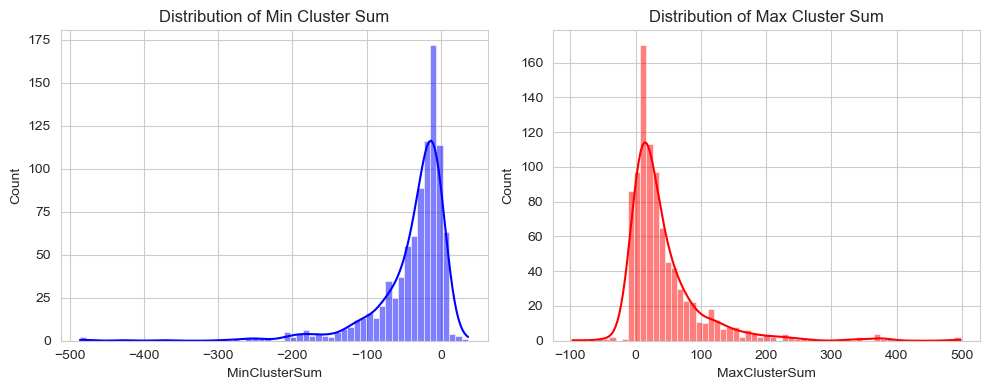

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Drop rows with NaN values
cluster_sums_df = cluster_sums_df.dropna(subset=['MinClusterSum', 'MaxClusterSum'])


# Assume you have a DataFrame named cluster_sums_df
# with columns 'MinClusterSum' and 'MaxClusterSum'

# Create a figure with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plot histogram of MinClusterSum
sns.histplot(data=cluster_sums_df, x='MinClusterSum', kde=True, ax=axs[0], color='blue')
axs[0].set_title('Distribution of Min Cluster Sum')

# Plot histogram of MaxClusterSum
sns.histplot(data=cluster_sums_df, x='MaxClusterSum', kde=True, ax=axs[1], color='red')
axs[1].set_title('Distribution of Max Cluster Sum')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


In [12]:
import numpy as np

alpha = 0.01
lower_pct = 100 * (alpha / 2)      # 2.5 percentile
upper_pct = 100 * (1 - alpha / 2)  # 97.5 percentile

# Calculate thresholds for MinClusterSum
min_lower_thresh = np.percentile(cluster_sums_df['MinClusterSum'], lower_pct)
min_upper_thresh = np.percentile(cluster_sums_df['MinClusterSum'], upper_pct)

# Calculate thresholds for MaxClusterSum
max_lower_thresh = np.percentile(cluster_sums_df['MaxClusterSum'], lower_pct)
max_upper_thresh = np.percentile(cluster_sums_df['MaxClusterSum'], upper_pct)

print(f"MinClusterSum thresholds (p=0.05, two-sided): {min_lower_thresh} to {min_upper_thresh}")
print(f"MaxClusterSum thresholds (p=0.05, two-sided): {max_lower_thresh} to {max_upper_thresh}")


MinClusterSum thresholds (p=0.05, two-sided): -282.46616549278997 to 14.056261755996974
MaxClusterSum thresholds (p=0.05, two-sided): -24.754532098871344 to 374.5955005951547


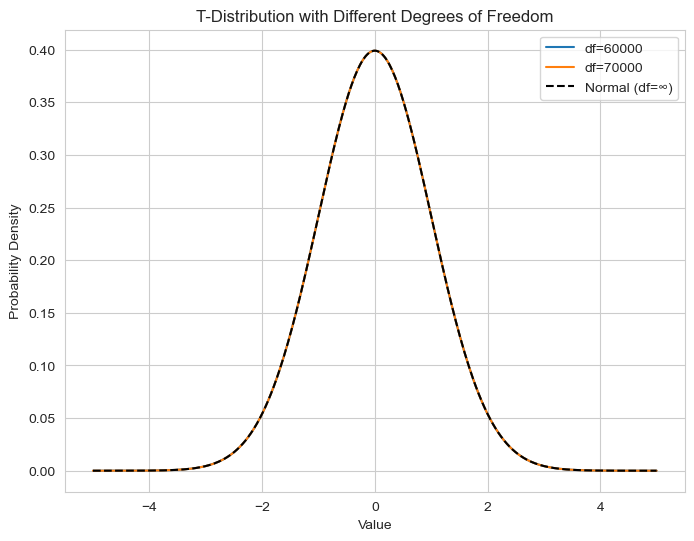

In [16]:
'''
learning 

how df influence the t distribution?
'''

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t

# Degrees of freedom to compare
dfs = [60000, 70000]

# Create an x-axis from -5 to 5
x = np.linspace(-5, 5, 400)

plt.figure(figsize=(8, 6))

for df in dfs:
    # Get the t-distribution PDF for this df
    pdf = t.pdf(x, df)
    plt.plot(x, pdf, label=f"df={df}")

# Also include the standard normal distribution for comparison
from scipy.stats import norm
plt.plot(x, norm.pdf(x), label="Normal (df=∞)", linestyle='--', color='black')

plt.title("T-Distribution with Different Degrees of Freedom")
plt.xlabel("Value")
plt.ylabel("Probability Density")
plt.legend()
plt.grid(True)
plt.show()


In [18]:
'''
instant code 

find files' name and delete files who have been updated.\

'''

import os

directory = r'H:\lyw\sub28'

# Print only file names
for root, dirs, files in os.walk(directory):
    for file in files:
        print(file)


clustersT_20250102_thresh_0.01.pkl
clusters_20250102_thresh_0.01.pkl
clusters_20250107_thresh_1.96.pkl
max_cluster_sums_permutation.csv
max_values_out.csv
max_values_out2.csv
max_values_out2_num_steps_1000.csv
max_values_out2_num_steps_10000.csv
max_values_out_num_steps_1000.csv
max_values_out_num_steps_10000.csv
min_max_cluster_sums_20241231_thresh_0.05.csv
min_max_cluster_sums_20250101_thresh_0.01.csv
min_max_cluster_sums_20250102_thresh_0.01.csv
min_max_cluster_sums_20250107_thresh_1.96.csv
min_max_cluster_sums_20250107_thresh_2.58.csv
min_max_cluster_sums_permutation.csv
min_values_out.csv
min_values_out2.csv
min_values_out2_num_steps_1000.csv
min_values_out2_num_steps_10000.csv
min_values_out_num_steps_1000.csv
min_values_out_num_steps_10000.csv
summary_permutation_111.rds
summary_permutation_112.rds
summary_permutation_113.rds
summary_permutation_114.rds
summary_permutation_115.rds
summary_permutation_116.rds
summary_permutation_117.rds
summary_permutation_118.rds
summary_permuta

In [19]:
import os
import re

# Define the directory path
directory = r'H:\lyw\sub28'

# Initialize a list to store numbers
numbers = []

# Walk through the directory
for root, dirs, files in os.walk(directory):
    for file in files:
        # Check if the file matches the pattern
        if re.match(r'summary_results_permutation_\d+\.csv', file):
            # Extract the number using regex
            num = re.search(r'\d+', file).group()
            numbers.append(int(num))

# Print the numbers
print("Extracted numbers:", numbers)


Extracted numbers: [1000, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 301, 302, 303, 304, 305, 306, 307, 308, 309, 31, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 32, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 33, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 34, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 35, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 36, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 37, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 38, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 39, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 40, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 41, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 42, 420, 421, 422, 423, 424, 425, 426, 427, 4

In [20]:
# Define the full range of numbers from 1 to 1000
full_range = set(range(1, 1001))

# Example extracted numbers (as a list)
extracted_numbers = numbers

# Convert the list to a set for set operations
extracted_numbers_set = set(extracted_numbers)

# Find missing numbers
missing_numbers = sorted(full_range - extracted_numbers_set)

# Display the missing numbers
print("Missing numbers:", missing_numbers)



Missing numbers: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 516, 517, 518, 519, 520, 521, 52